<a href="https://colab.research.google.com/github/akibkhan1/skin-lesion-classification/blob/main/Skin_Lesion_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import random
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from shutil import copyfile, move

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6045451478599563660, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9018551382253825584
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# Download training data

In [ ]:
!gdown --id 15w8elcm9BwfG2-bU-UOLtRBiiaGdpjr0

Downloading...
From: https://drive.google.com/uc?id=15w8elcm9BwfG2-bU-UOLtRBiiaGdpjr0
To: /content/skin-lesion-split.zip
3.60GB [00:59, 60.1MB/s]


In [ ]:
!unzip skin-lesion-split.zip

Archive:  skin-lesion-split.zip
   creating: skin-lesion-split/
   creating: skin-lesion-split/testing/
   creating: skin-lesion-split/testing/MEL/
  inflating: skin-lesion-split/testing/MEL/PAT_949_1802_582.png  
  inflating: skin-lesion-split/testing/MEL/PAT_320_681_410.png  
  inflating: skin-lesion-split/testing/MEL/PAT_966_1825_584.png  
   creating: skin-lesion-split/testing/SCC/
  inflating: skin-lesion-split/testing/SCC/PAT_359_741_973.png  
  inflating: skin-lesion-split/testing/SCC/PAT_386_784_470.png  
  inflating: skin-lesion-split/testing/SCC/PAT_570_1084_939.png  
  inflating: skin-lesion-split/testing/SCC/PAT_271_418_14.png  
  inflating: skin-lesion-split/testing/SCC/PAT_20_30_44.png  
  inflating: skin-lesion-split/testing/SCC/PAT_924_1757_784.png  
  inflating: skin-lesion-split/testing/SCC/PAT_612_1163_833.png  
  inflating: skin-lesion-split/testing/SCC/PAT_857_1627_310.png  
  inflating: skin-lesion-split/testing/SCC/PAT_500_947_77.png  
  inflating: skin-lesion-sp

In [ ]:
BASE_MODEL='RESNET52'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL == 'MobileNet':
    from keras.applications.mobilenet_v2 import MobileNetV2 as PTModel, preprocess_input
elif BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

In [ ]:
base_pretrained_model = PTModel(input_shape =  (400,400,3), 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = True

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
base_pretrained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 406, 406, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 200, 200, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 200, 200, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
last_layer = base_pretrained_model.get_layer('conv5_block3_2_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 13, 13, 512)


In [ ]:
from tensorflow.keras.optimizers import Adam

x = layers.BatchNormalization()(last_output)
x = layers.SpatialDropout2D(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(6, activation='softmax')(x)           

model = Model(base_pretrained_model.input, x)

model.compile(optimizer = Adam(lr=0.0001), 
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 406, 406, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 200, 200, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 200, 200, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
TRAINING_DIR = "/content/skin-lesion-split/training/"

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (400, 400),
    batch_size = 16,
    class_mode = 'categorical'
)

VALIDATION_DIR = "/content/skin-lesion-split/validation/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size = (400, 400),
    batch_size = 16,
    class_mode = 'categorical'
)

Found 1958 images belonging to 6 classes.
Found 222 images belonging to 6 classes.


In [ ]:
TEST_DIR = "/content/skin-lesion-split/testing/"
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = (400, 400),
    batch_size = 8,
    class_mode = 'categorical'
)

test_x , test_y = next(test_generator)

Found 118 images belonging to 6 classes.


In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('skin-lesion-classification')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
history = model.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              callbacks = callbacks_list,
                              validation_data=validation_generator)

Epoch 1/20
123/123 [==============================] - 163s 1s/step - loss: 0.9567 - accuracy: 0.3413 - val_loss: 11.6469 - val_accuracy: 0.0856

Epoch 00001: val_loss improved from inf to 11.64690, saving model to skin-lesion-classification_weights.best.hdf5
Epoch 2/20
123/123 [==============================] - 155s 1s/step - loss: 0.3801 - accuracy: 0.5270 - val_loss: 1.8346 - val_accuracy: 0.1081

Epoch 00002: val_loss improved from 11.64690 to 1.83459, saving model to skin-lesion-classification_weights.best.hdf5
Epoch 3/20
123/123 [==============================] - 159s 1s/step - loss: 0.3438 - accuracy: 0.5792 - val_loss: 0.9055 - val_accuracy: 0.1081

Epoch 00003: val_loss improved from 1.83459 to 0.90554, saving model to skin-lesion-classification_weights.best.hdf5
Epoch 4/20
123/123 [==============================] - 157s 1s/step - loss: 0.3132 - accuracy: 0.6229 - val_loss: 0.7453 - val_accuracy: 0.0946

Epoch 00004: val_loss improved from 0.90554 to 0.74534, saving model to sk

Text(0.5, 1.0, 'Training and validation loss')

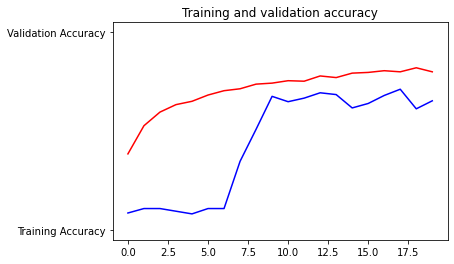

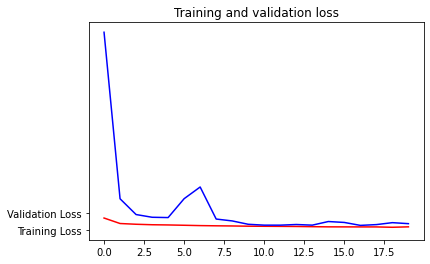

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [ ]:
!gdown --id '1XrieFe-vJFfcg1-NGUrtvz63QTiukiTi'

Downloading...
From: https://drive.google.com/uc?id=1XrieFe-vJFfcg1-NGUrtvz63QTiukiTi
To: /content/path_label.csv
100% 56.9k/56.9k [00:00<00:00, 26.7MB/s]


In [ ]:
files = pd.read_csv('path_label.csv')
files.head(5)

,img_id,diagnostic
0,PAT_1516_1765_530.png,NEV
1,PAT_46_881_939.png,BCC
2,PAT_1545_1867_547.png,ACK
3,PAT_1989_4061_934.png,ACK
4,PAT_684_1302_588.png,BCC


In [ ]:
files[files['diagnostic'] == 'NEV'].iloc

img_id        PAT_1516_1765_530.png
diagnostic                      NEV
Name: 0, dtype: object

In [ ]:
t_x, t_y = test_x, test_y
t_yp = model.predict(t_x, batch_size=118, verbose=True)

1/1 [==============================] - 1s 894ms/step


In [ ]:
count=0
for i in range(len(t_y)):
  label = np.argmax(t_y[i], axis = 0)
  pred = np.argmax(t_yp[i], axis = 0)
  if label == pred:
    count +=1

accuracy = (count * 100)/ len(t_y)
print(accuracy) 



62.5
